In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 머신러닝을 이용한 교통 흐름 데이터 결정 경계 가시화 

### 필요한 라이브러리 불러오기

In [2]:

# mlxtend가 설치가 안되어 있으면 아래 명령어로 설치하세요.
!pip install mlxtend  
from mlxtend.plotting import plot_decision_regions

In [3]:
# 맷플랏립에서 한글을 사용한고자 한다면 아래와 같이
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [4]:
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

from livelossplot import PlotLossesKeras
from keras.utils import to_categorical

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [6]:
df['new_Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M')

In [7]:
df['time'] = df['new_Date'].dt.time
df['hour'] = df['new_Date'].dt.hour
df['day'] = df['new_Date'].dt.day
df['day_name'] = df['new_Date'].dt.day_name()
df['weekday'] = df['new_Date'].dt.weekday

In [8]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,new_Date,time,hour,day,day_name,weekday
0,2017-04-02 0:00,43,34,9,0,50.3,1.90,2017-04-02 00:00:00,00:00:00,0,2,Sunday,6
1,2017-04-02 0:05,45,32,13,0,58.9,1.84,2017-04-02 00:05:00,00:05:00,0,2,Sunday,6
2,2017-04-02 0:10,46,34,12,0,50.6,1.87,2017-04-02 00:10:00,00:10:00,0,2,Sunday,6
3,2017-04-02 0:15,45,36,9,0,50.9,1.72,2017-04-02 00:15:00,00:15:00,0,2,Sunday,6
4,2017-04-02 0:20,27,13,13,1,62.2,1.12,2017-04-02 00:20:00,00:20:00,0,2,Sunday,6


In [9]:
df=df[df.weekday.isin([0,1,2,3,4])]

In [10]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,new_Date,time,hour,day,day_name,weekday
288,2017-04-03 0:00,30,21,9,0,58.6,1.09,2017-04-03 00:00:00,00:00:00,0,3,Monday,0
289,2017-04-03 0:05,28,17,11,0,57.5,1.29,2017-04-03 00:05:00,00:05:00,0,3,Monday,0
290,2017-04-03 0:10,42,33,8,1,53.1,1.53,2017-04-03 00:10:00,00:10:00,0,3,Monday,0
291,2017-04-03 0:15,32,22,9,1,56.2,1.25,2017-04-03 00:15:00,00:15:00,0,3,Monday,0
292,2017-04-03 0:20,22,15,7,0,52.8,1.02,2017-04-03 00:20:00,00:20:00,0,3,Monday,0


In [11]:
print(df['weekday'].unique())

[0 1 2 3 4]


In [12]:
df=df.reset_index(drop=True)

In [13]:
### <a > Matplotlib을 이용하여 특성 가시화 </a>
# 5분 단위로 가공된 데이터를 2일 간 그리고자 한다면
nsize = 288

Text(0, 0.5, '교통량')

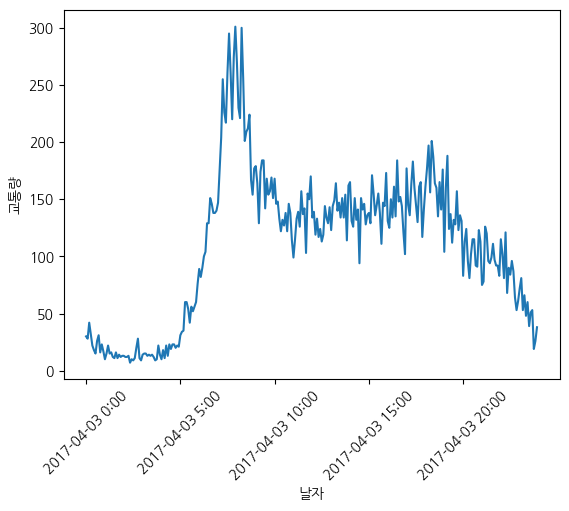

In [14]:
# x-축으로 날짜를 표시하고자 한다면
#plt.plot(df.index[0:nsize],df["ToVol"][0:nsize],label='ToVol')
plt.plot(df["Date"][0:nsize],df["ToVol"][0:nsize],label='ToVol')
plt.xticks(np.arange(0,nsize,60),rotation=45)
plt.xlabel('날자')
plt.ylabel('교통량')


Text(0, 0.5, '점유율')

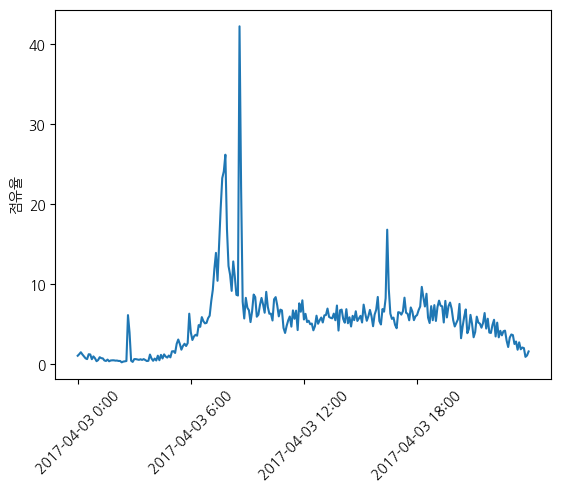

In [15]:
plt.plot(df["Date"][0:nsize],df["OccRate"][0:nsize])
#plt.plot(df.index[0:nsize],df["OccRate"][0:nsize])
plt.xticks(np.arange(0,nsize,72),rotation=45)
plt.ylabel('점유율')

Text(0, 0.5, '차량속도')

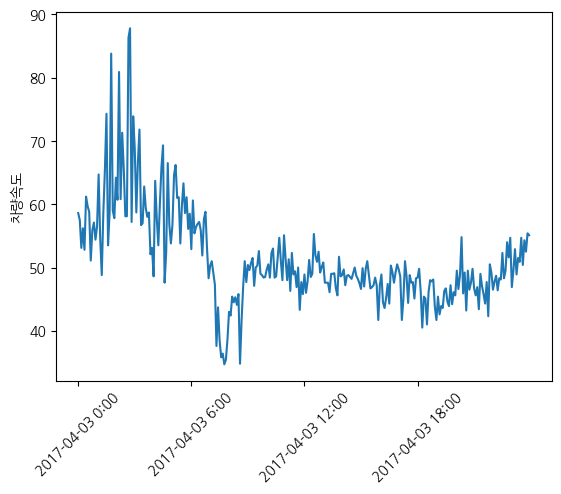

In [16]:
plt.plot(df["Date"][0:nsize],df["Speed"][0:nsize])
#plt.plot(df.index[0:nsize],df["OccRate"][0:nsize])
plt.xticks(np.arange(0,nsize,72),rotation=45)
plt.ylabel('차량속도')

### <a > VDS 데이터 라벨링 전략 </a>
#### 분류를 위한 클래스가 3개인 경우

In [17]:
num_classes = 3

# 라벨을 위한 함수를 만들자
def speed_score(speed):
    if speed < 40:
        label = 'Jam'
    elif speed < 55:
        label = 'Slow'
    else :
        label = 'Fast'
    return label


def volume_score(x):
    if x < 100:
        label = 'Fast'
    elif x > 200:
        label = 'Jam'
    else :
        label = 'Slow'
    return label


def hour_score(hour):
    if ( hour < 7 and hour >0) or (hour <=24 and hour > 20):
        label = 'Fast'
    elif (hour >= 7 and hour <= 9) or (hour >= 18 and hour <= 20 ) :
        label = 'Jam'
    else :
        label = 'Slow'
    return label


In [18]:
# speed로 라벨한 경우
df["label"] = df["Speed"].apply(lambda x: speed_score(x))

In [19]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,new_Date,time,hour,day,day_name,weekday,label
0,2017-04-03 0:00,30,21,9,0,58.6,1.09,2017-04-03 00:00:00,00:00:00,0,3,Monday,0,Fast
1,2017-04-03 0:05,28,17,11,0,57.5,1.29,2017-04-03 00:05:00,00:05:00,0,3,Monday,0,Fast
2,2017-04-03 0:10,42,33,8,1,53.1,1.53,2017-04-03 00:10:00,00:10:00,0,3,Monday,0,Slow
3,2017-04-03 0:15,32,22,9,1,56.2,1.25,2017-04-03 00:15:00,00:15:00,0,3,Monday,0,Fast
4,2017-04-03 0:20,22,15,7,0,52.8,1.02,2017-04-03 00:20:00,00:20:00,0,3,Monday,0,Slow


In [20]:
label = df['label'].unique()
label

array(['Fast', 'Slow', 'Jam'], dtype=object)

### <a > Seaborn을 이용한 상관관계 등 가시화 </a>

<Axes: xlabel='label', ylabel='count'>

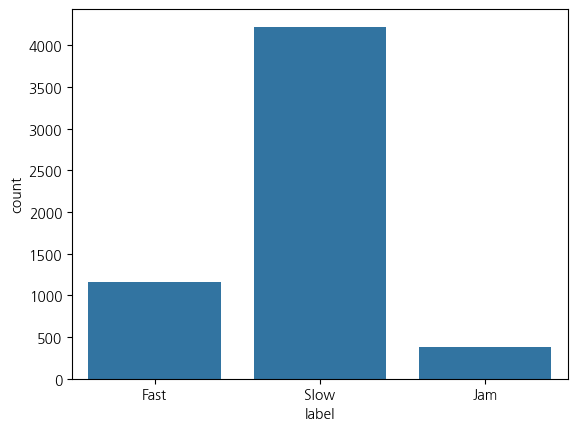

In [21]:
sns.countplot(x="label", data=df)

<Axes: xlabel='hour', ylabel='ToVol'>

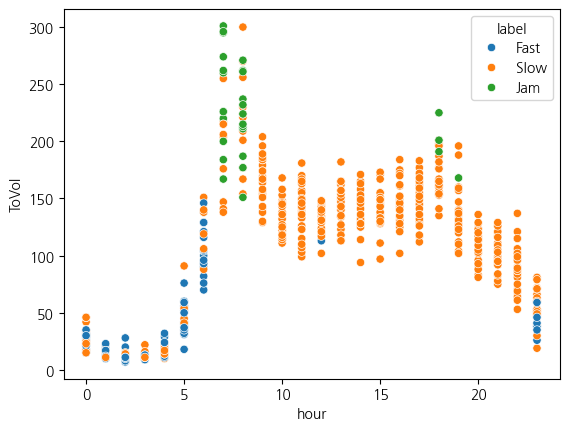

In [22]:
sns.scatterplot(data=df[:576], x = 'hour', y = 'ToVol', hue='label') 

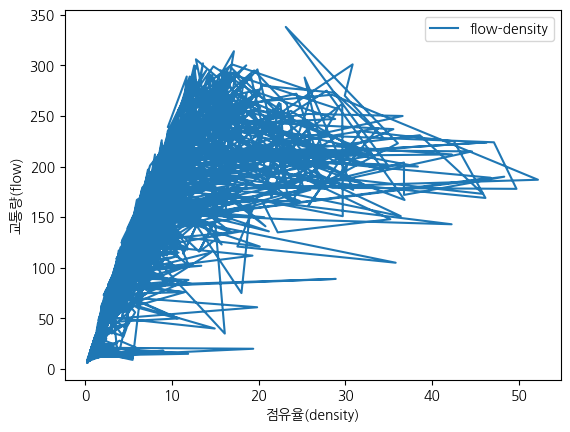

In [23]:
plt.plot(df["OccRate"],df["ToVol"],label='flow-density')
plt.ylabel('교통량(flow)')
plt.xlabel('점유율(density)')
plt.legend()
plt.show()

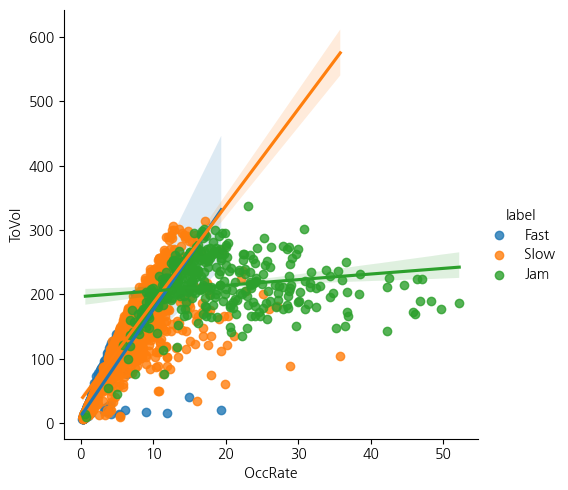

In [24]:
sns.lmplot(x="OccRate", y="ToVol", hue="label", data=df)

# <a > 머신러닝 적용하기 </a>

#### 특성과 라벨에 대하여 논의사항
- 특성 중에서 ToVol=LaVol+MeVol+SmVol이다
- Speed를 이용하여 label을 만들었다.
- Speed를 특성 포함하는 것이 올바른가? 아니면 제외하는 것이 올바른 것인가?

# 입력 특성 X 다루기
### X_train을 위하여 sklearn.preprocessing에 StandardScaler를 이용하자.

In [25]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,new_Date,time,hour,day,day_name,weekday,label
0,2017-04-03 0:00,30,21,9,0,58.6,1.09,2017-04-03 00:00:00,00:00:00,0,3,Monday,0,Fast
1,2017-04-03 0:05,28,17,11,0,57.5,1.29,2017-04-03 00:05:00,00:05:00,0,3,Monday,0,Fast
2,2017-04-03 0:10,42,33,8,1,53.1,1.53,2017-04-03 00:10:00,00:10:00,0,3,Monday,0,Slow
3,2017-04-03 0:15,32,22,9,1,56.2,1.25,2017-04-03 00:15:00,00:15:00,0,3,Monday,0,Fast
4,2017-04-03 0:20,22,15,7,0,52.8,1.02,2017-04-03 00:20:00,00:20:00,0,3,Monday,0,Slow


In [26]:
# 라벨을 'Speed'에서 만들어서 'Speed'는 특성에서 제외하자.

X = df[[ 'OccRate', 'ToVol']]
print(X.shape)
print(X)


(5760, 2)
      OccRate  ToVol
0        1.09     30
1        1.29     28
2        1.53     42
3        1.25     32
4        1.02     22
...       ...    ...
5755     2.09     46
5756     2.29     55
5757     3.00     81
5758     1.69     45
5759     2.46     53

[5760 rows x 2 columns]


In [27]:
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#X_scaled = StandardScaler().fit_transform(X)
#print(X_scaled.shape)
# print(X_scaled)
## X_scaled는 numpy array로 변경되었다. 

# 레이블 y 다루기
### sklearn.preprocessing에 LabelEncoder를 이용하자
- 라벨(y)는 텍스트로 되어 있어서 숫자로 바꾸자
- 라벨 개수 num_classes에 맞도록 LabelEncoder()로 인코딩 해보자

In [28]:
y = df['label']
print(y)

0       Fast
1       Fast
2       Slow
3       Fast
4       Slow
        ... 
5755    Slow
5756    Fast
5757    Fast
5758    Fast
5759    Slow
Name: label, Length: 5760, dtype: object


In [29]:
y = LabelEncoder().fit_transform(y)
print(y)

[0 0 2 ... 0 0 2]


In [30]:
# OneHot encoding
#y_onehot = to_categorical(y_enc)
# print(y_onehot)

### <a >  Train/Test 데이터 나누기 </a >

In [31]:
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report,  accuracy_score, confusion_matrix

from mlxtend.plotting import plot_decision_regions
#!pip install mlxtend

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
print(X_train)

      OccRate  ToVol
1946     8.96    198
3562     7.90    161
763      6.22    141
5707     6.39    109
3141     4.19     76
...       ...    ...
4931     0.31      9
3264    11.07    252
1653     7.42    179
2607     1.46     31
2732     7.40    163

[4608 rows x 2 columns]


In [34]:
print(y_train)

[2 2 2 ... 2 0 2]


In [35]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(4608, 2) (4608,)
(1152, 2) (1152,)


# <a id='list'> List of algorithms</a>

Since it is a classification problem we will be using<br>
Logistic regression<br>
Decision tree<br>
Random forest<br>
KNN<br>
SVM<br>
GBoost<br>

# 1)  <a id='logistic'>Logistic regression</a><br>

<img src = "https://image.slidesharecdn.com/logitregression-161121215510/95/intro-to-logistic-regression-4-638.jpg?cb=1479765630">

In [36]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [37]:
print(y_pred)
print(y_test)

[2 2 2 ... 2 0 0]
[2 2 0 ... 2 2 2]


In [38]:

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.79      0.74       223
           1       0.82      0.64      0.72        66
           2       0.92      0.90      0.91       863

    accuracy                           0.86      1152
   macro avg       0.81      0.78      0.79      1152
weighted avg       0.87      0.86      0.87      1152



In [39]:
print(confusion_matrix(y_test, y_pred))


[[177   0  46]
 [  0  42  24]
 [ 77   9 777]]


In [40]:
# Accuracy score
acc_lr=accuracy_score(y_pred,y_test)
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.8645833333333334


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


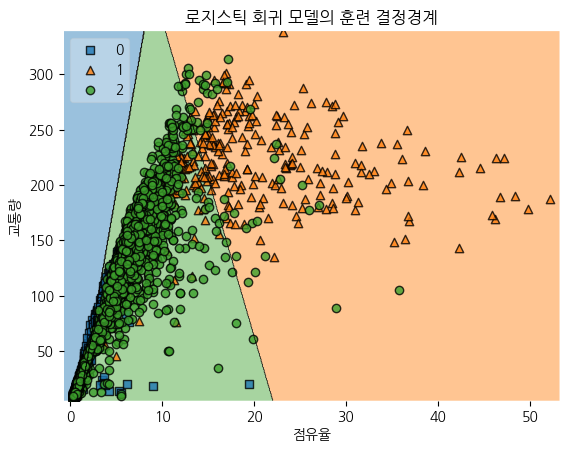

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


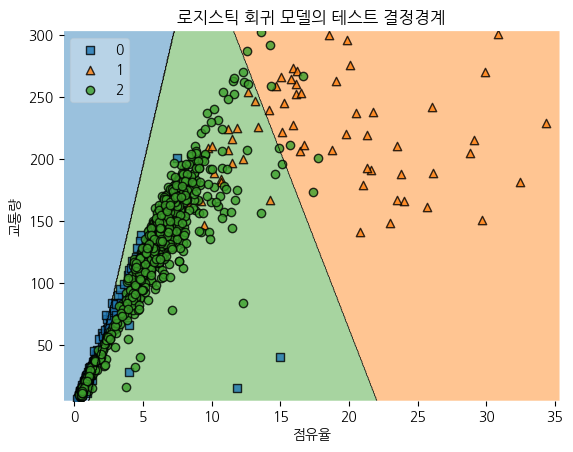

In [41]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('로지스틱 회귀 모델의 훈련 결정경계')
plt.show()

# 테스트 과정 
plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('로지스틱 회귀 모델의 테스트 결정경계')
plt.show()


# 2) <a id='svm'>SVM</a><br>

<img src = "https://cdn-images-1.medium.com/max/1600/1*TudH6YvvH7-h5ZyF2dJV2w.jpeg">

**“Support Vector Machine” (SVM)** is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well.

Support Vectors are simply the co-ordinates of individual observation. Support Vector Machine is a frontier which best segregates the two classes (hyper-plane/ line).
(https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)


In [42]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
acc_svc=accuracy_score(y_pred,y_test)
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       223
           1       0.74      0.64      0.68        66
           2       0.92      0.87      0.89       863

    accuracy                           0.85      1152
   macro avg       0.77      0.77      0.77      1152
weighted avg       0.86      0.85      0.85      1152

[[179   0  44]
 [  0  42  24]
 [ 95  15 753]]
accuracy is 0.8454861111111112


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


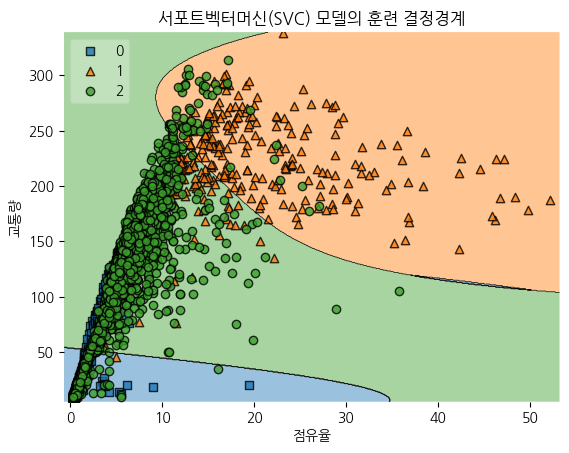

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


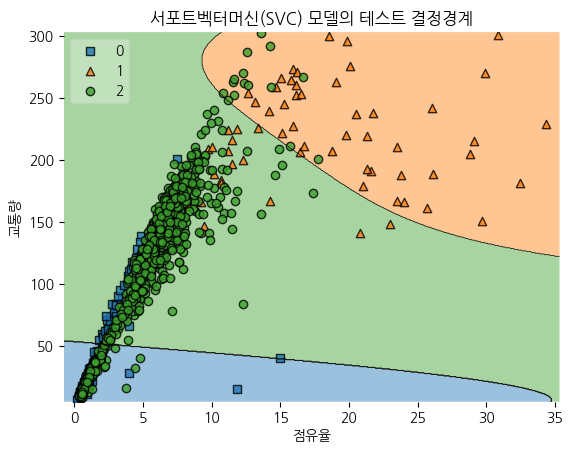

In [43]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('서포트벡터머신(SVC) 모델의 훈련 결정경계')
plt.show()

# 테스트 과정 
plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('서포트벡터머신(SVC) 모델의 테스트 결정경계')
plt.show()

# 3) <a id='decision'>Decision tree</a><br>

<img src = "https://annalyzin.files.wordpress.com/2016/07/decision-trees-titanic-tutorial.png">

In [44]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
acc_dt=accuracy_score(y_pred,y_test)
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       223
           1       0.71      0.77      0.74        66
           2       0.92      0.88      0.90       863

    accuracy                           0.85      1152
   macro avg       0.76      0.80      0.78      1152
weighted avg       0.86      0.85      0.85      1152

[[168   0  55]
 [  0  51  15]
 [ 83  21 759]]
accuracy is 0.8489583333333334


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


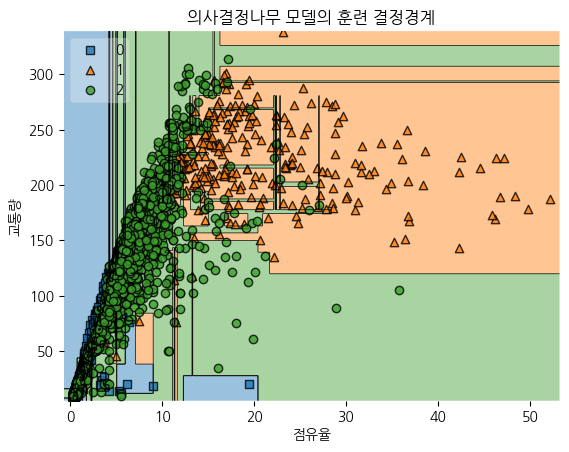

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


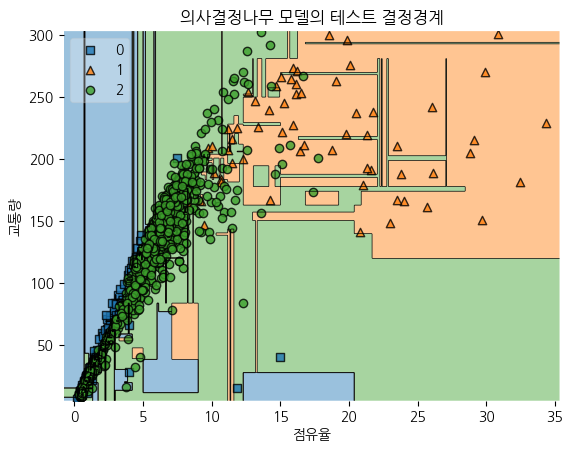

In [45]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('의사결정나무 모델의 훈련 결정경계')
plt.show()

# 테스트 과정 
plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('의사결정나무 모델의 테스트 결정경계')
plt.show()

# 4) Random Forest Classification

<img src="https://i1.wp.com/dataaspirant.com/wp-content/uploads/2017/04/Random-Forest-Introduction.jpg?resize=690%2C345">

In [46]:
rf=RandomForestClassifier(max_depth=2)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
acc_rf=accuracy_score(y_pred,y_test)
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       223
           1       0.73      0.50      0.59        66
           2       0.90      0.89      0.89       863

    accuracy                           0.84      1152
   macro avg       0.77      0.72      0.74      1152
weighted avg       0.85      0.84      0.84      1152

[[174   0  86]
 [  0  33  12]
 [ 49  33 765]]
accuracy is  0.84375


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


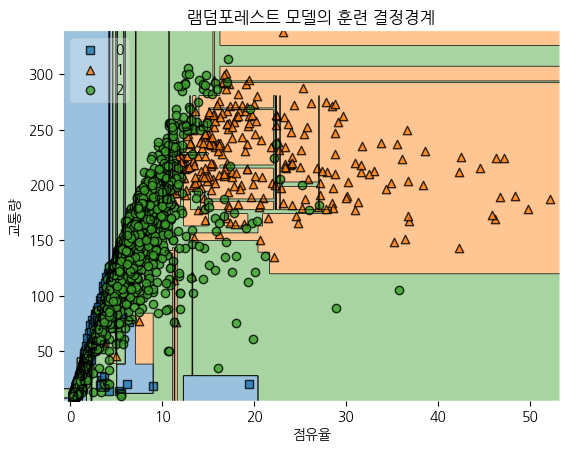

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


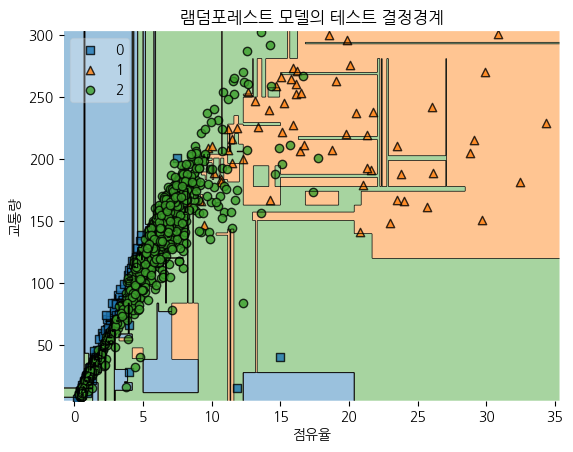

In [47]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('램덤포레스트 모델의 훈련 결정경계')
plt.show()

# 테스트 과정 
plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('램덤포레스트 모델의 테스트 결정경계')
plt.show()

# 5) <a id='knn'>KNN</a><br>

<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/Knn_k1_z96jba.png">

**K nearest neighbors** is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition already in the beginning of 1970's as a non-parametric technique.
(https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)

In [48]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

model= KNeighborsClassifier(n_neighbors=8)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
acc_knn=accuracy_score(y_pred,y_test)
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       223
           1       0.74      0.68      0.71        66
           2       0.92      0.88      0.90       863

    accuracy                           0.85      1152
   macro avg       0.77      0.78      0.78      1152
weighted avg       0.86      0.85      0.85      1152

[[175   0  48]
 [  0  45  21]
 [ 88  16 759]]
accuracy is 0.8498263888888888


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


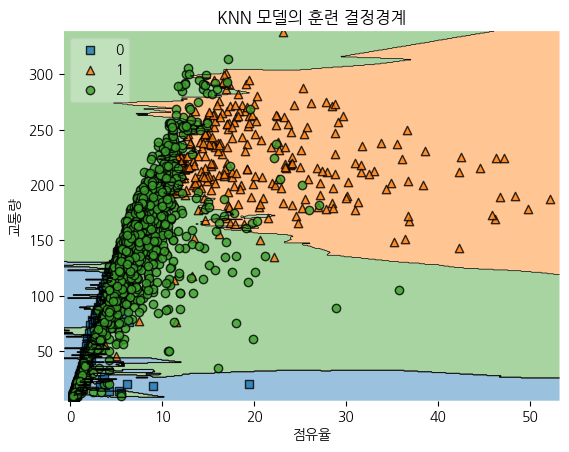

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


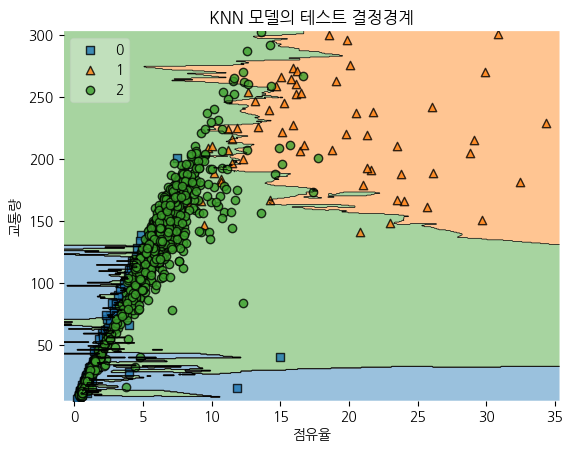

In [49]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('KNN 모델의 훈련 결정경계')
plt.show()

# 테스트 과정 
plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('KNN 모델의 테스트 결정경계')
plt.show()

# 6) <a id=' Gradient Boosting Classifier'>GradientBoosting</a><br>

* Gradient boosting is one of the most powerful techniques for building **predictive models**.
* The idea of boosting came out of the idea of whether a weak learner can be modified to become better.
* A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance.
* Gradient boosting is a **greedy algorithm** and can overfit a training dataset quickly.
* GB builds an additive model in a forward stage-wise fashion.

<img src="https://uc-r.github.io/public/images/analytics/gbm/boosted-trees-process.png">

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))

#Accuracy Score
acc_gb=accuracy_score(y_pred,y_test)
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       223
           1       0.81      0.70      0.75        66
           2       0.94      0.90      0.92       863

    accuracy                           0.88      1152
   macro avg       0.82      0.82      0.82      1152
weighted avg       0.89      0.88      0.88      1152

[[194   0  75]
 [  0  46  11]
 [ 29  20 777]]
accuracy is  0.8828125


c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


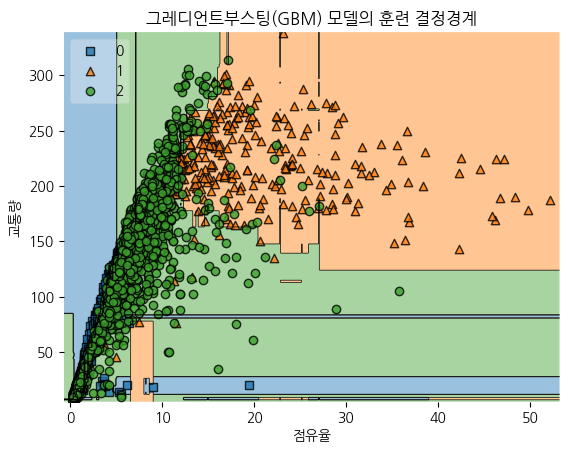

c:\Users\admin\anaconda3\envs\tfgpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


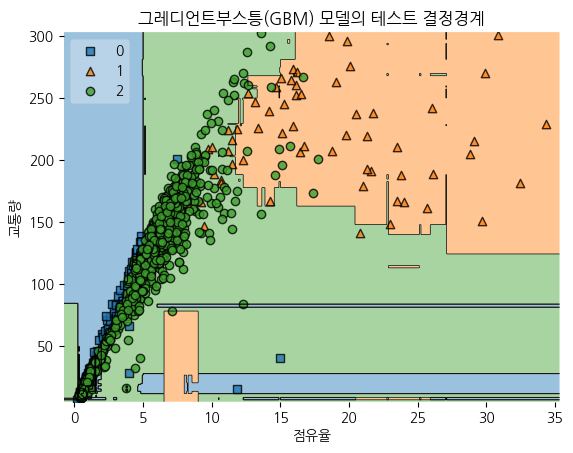

In [51]:
# 훈련 과정 
plot_decision_regions(X_train.values, y_train, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('그레디언트부스팅(GBM) 모델의 훈련 결정경계')
plt.show()

plot_decision_regions(X_test.values, y_test, clf=model, legend=2)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('그레디언트부스틍(GBM) 모델의 테스트 결정경계')
plt.show()

<Axes: xlabel='models'>

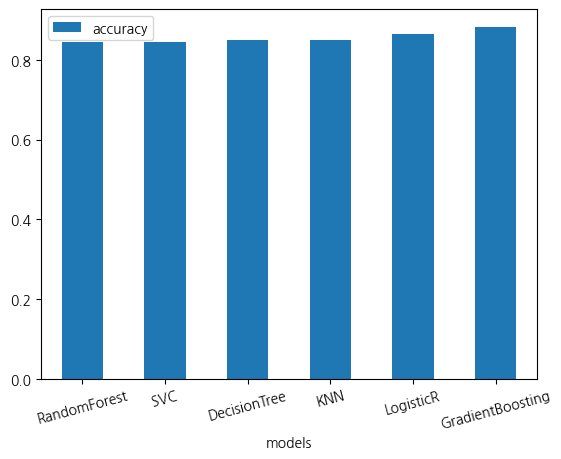

In [52]:
df = pd.DataFrame({
    'models': ['LogisticR', 'SVC', 'DecisionTree','RandomForest','KNN', 'GradientBoosting'],
    'accuracy':[acc_lr, acc_svc, acc_dt, acc_rf, acc_knn, acc_gb]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

In [53]:
def dnn_4():    
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation = 'relu', kernel_initializer='he_uniform'),
        Dense(32, activation= 'relu'),
        #Dense(16, activation= 'relu'),
        Dense(num_classes, activation= 'softmax')
    ])  
    model.compile(loss="sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.005), metrics = ['accuracy'])
    return model

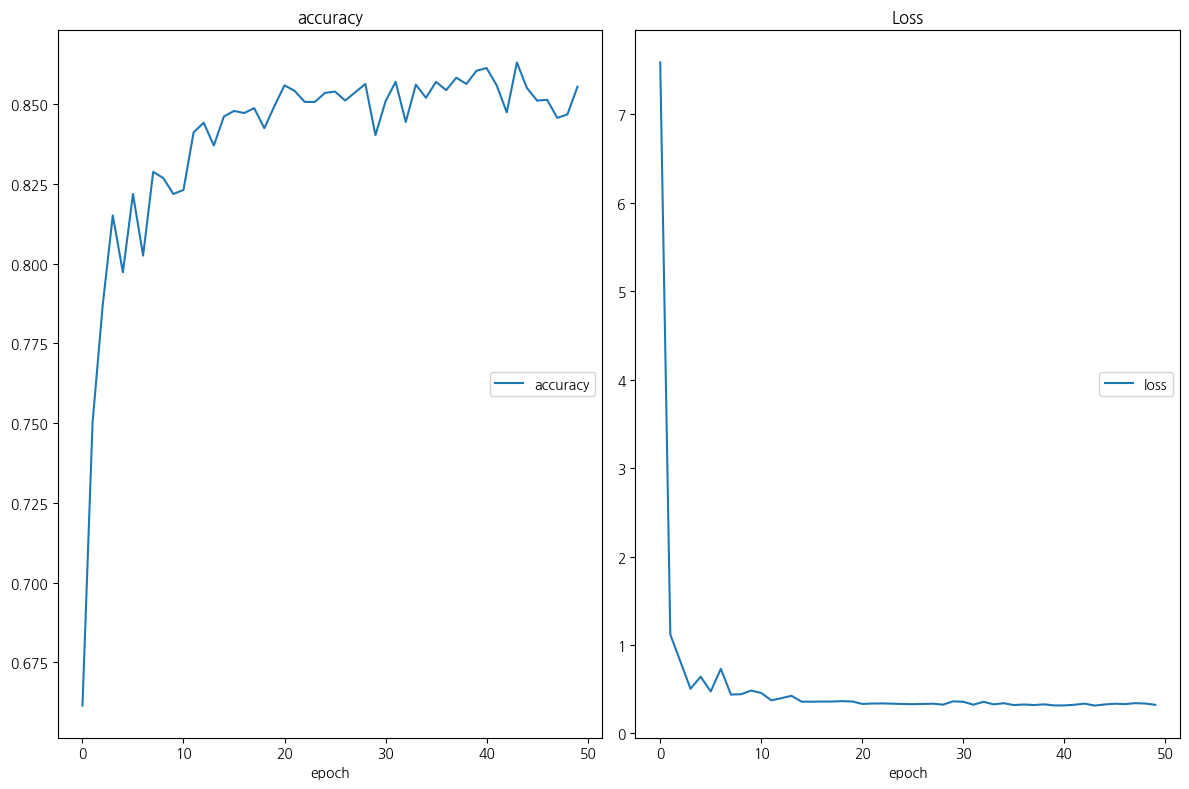

accuracy
	accuracy         	 (min:    0.661, max:    0.863, cur:    0.855)
Loss
	loss             	 (min:    0.316, max:    7.583, cur:    0.324)
144/144 [==============================] - 1s 10ms/step - loss: 0.3241 - accuracy: 0.8555


In [54]:
model = dnn_4()
#history = model.fit(X_train,y_train, epochs=100, validation_split=0.2)
#history = model.fit(X_train,y_train, epochs=10, validation_split=0.2, callbacks=[PlotLossesKeras()])
history = model.fit(X_train,y_train, epochs=50, validation_split=0.0, callbacks=[PlotLossesKeras()])

In [55]:
_, acc_dnn4 = model.evaluate(X_test,y_test)
print(acc_dnn4)

36/36 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8741
0.8741319179534912


In [56]:
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)   

In [57]:
# 테스트 과정에서 validation 데이터를 0으로 하면 에러를 해결한다. 

model_one =Onehot2Int(model)

9600/9600 [==============================] - 25s 3ms/step


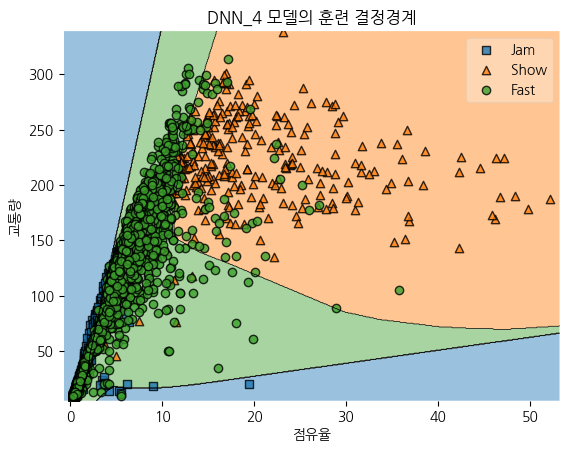

9600/9600 [==============================] - 24s 3ms/step


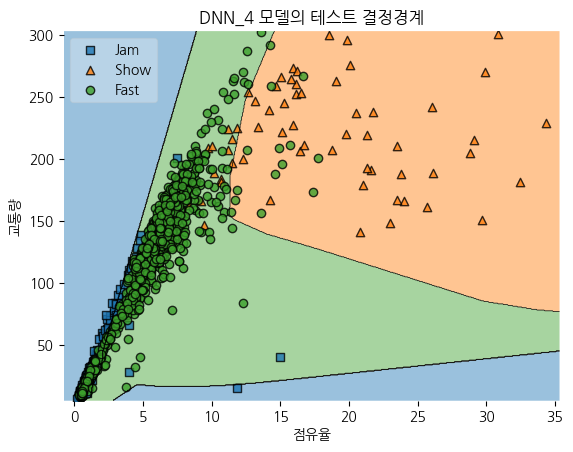

In [58]:
# 훈련 과정 
ax = plot_decision_regions(X_train.values, y_train, clf=model_one)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('DNN_4 모델의 훈련 결정경계')
handles, labels = ax.get_legend_handles_labels()
if num_classes == 3 : 
    ax.legend(handles, [ 'Jam', 'Show', 'Fast'],  framealpha=0.3, scatterpoints=1)
plt.show()

ax=plot_decision_regions(X_test.values, y_test, clf=model_one)
plt.xlabel('점유율')
plt.ylabel('교통량')
plt.title('DNN_4 모델의 테스트 결정경계')
handles, labels = ax.get_legend_handles_labels()
if num_classes == 3 : 
    ax.legend(handles, [ 'Jam', 'Show', 'Fast'],  framealpha=0.3, scatterpoints=1)
plt.show()

<Axes: xlabel='models'>

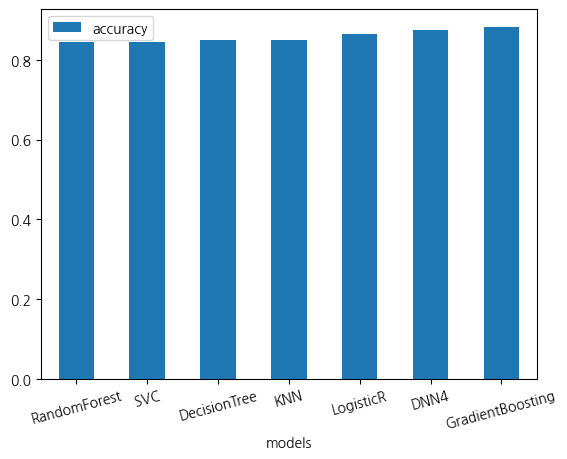

In [59]:
df = pd.DataFrame({
    'models': ['LogisticR', 'SVC', 'DecisionTree','RandomForest','KNN', 'GradientBoosting','DNN4'],
    'accuracy':[acc_lr, acc_svc, acc_dt, acc_rf, acc_knn, acc_gb, acc_dnn4]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)